**Introduction**

In this prototype model I am looking to create a basic classification model based on a dataset containing 1600 reviews, half being a mixture of truthful and the other half being deceptive. The deceptive reviews are from amazons mechanical turk program, where participants are told to create a review based on an experience they had never had. My aim is that by creating an initial model based on human deception, I will be able to later adapt the model with further training and tweaking into finding the different type of langauge used by a machines produced fake review.

The dataset being used was created by a mixture of data from two studies into computational linguistics; M. Ott, Y. Choi, C. Cardie, and J.T. Hancock. [2011] and M. Ott, C. Cardie, and J.T. Hancock. [2013]. Data that is truthful are real reviews for hotels in Chicago taken from the sites Expedia, Hotels.com, Orbitz, Priceline, TripAdvisor and Yelp.


In [1]:
import os
import numpy as np
from tensorflow import keras
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'
os.environ["TFHUB_CACHE_DIR"] = '/tmp/tfhub'

url = 'https://raw.githubusercontent.com/thestianchris/FakeReviewDetect/main/deceptive-opinion.csv'
df = pd.read_csv(url)
print(df.shape)
df.sample()

(1600, 5)


,deceptive,hotel,polarity,source,text
1140,truthful,palmer,negative,Web,How about this had reservation confirmation in...


In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 14217231332869025747
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 5717884928
locality {
  bus_id: 1
  links {
  }
}
incarnation: 5150606880270742717
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3070, pci bus id: 0000:08:00.0, compute capability: 8.6"
xla_global_id: 416903419
]


**Methodology**

Commonsense baseline for indication of a deceptive or truthful review comes at a level of 50% accuracy if taken at a random guess

standardize the data, token and indexing

Standardise the text data in order to get rid of any encoding issues that might give different weight to text data based on capitalization and punctuation differences.

tokenize using word2vec

using lstm model

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

#Standardise
for columns in df.columns:
    df['text'] = df['text'].str.lower()   #Covert the text to lower case
    df['text'].str.replace('[^\w\s]','') #Remove punctuation
    df['text'].str.strip() #Remove whitespace
    df['text'].str.replace("\n", " ") #Remove escape characters

#Shuffle the dataset to stop the model from picking up pattern of deceptive then truthful
df = shuffle(df)

#Get the max token from training data to be used in model
max_length = 0
for row in df['text']:
    if len(row.split(" ")) > max_length:
        max_length = len(row.split(" "))

print(max_length)

text_data = df['text'].values  #Get the data from the dataset to be used in model, we only are focused on the review and deceptive label
labels = df['deceptive'].values

#Split the data into test and train data with a 80/20 split, with 80% going to the train data
test_data, train_data, test_label, train_label = train_test_split(text_data,labels, test_size = 0.8, random_state = 0)

print(len(test_data))

784
320


C:\Users\Christian Gauthier\AppData\Local\Temp\ipykernel_6172\2821475478.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
  df['text'].str.replace('[^\w\s]','') #Remove punctuation


In [4]:
# Load Pretrained Word2Vec
import tensorflow_hub as hub
embed = hub.load('Embed')
embeddings = embed(["A long sentence.", "single-word", "http://example.com"])
print(embeddings.shape, embeddings.dtype)


(3, 500) <dtype: 'float32'>


In [2]:
def get_word2vec_enc(reviews):
    encoded_reviews = []
    for review in reviews:
        tokens = review.split(" ")
        word2vec_embedding = embed(tokens)
        encoded_reviews.append(word2vec_embedding)
    return encoded_reviews

def get_padded_encoded_reviews(encoded_reviews):
    #Pad all the reviews so that they have the same length for model 
    padded_reviews_encoding = []
    for enc_review in encoded_reviews:
        zero_padding_cnt = max_length - enc_review.shape[0]
        pad = np.zeros((1, 500)) #Value of 500 used as we are making a vector size of 500 word relation
        for i in range(zero_padding_cnt):
            enc_review = np.concatenate((pad, enc_review), axis=0)
        padded_reviews_encoding.append(enc_review)
    return padded_reviews_encoding

def label_encode(label):
    #encode label (One Hot)
    if label == 'truthful':
        return [1,0]
    else:
        return [0,1]

In [6]:
#Encode the reviews
'''
padded_encoded__train_reviews = get_padded_encoded_reviews(get_word2vec_enc(train_data))
padded_encoded__test_reviews = get_padded_encoded_reviews(get_word2vec_enc(test_data))
#Encode the labels
encoded_train_label = [label_encode(label) for label in train_label]
encoded_test_label = [label_encode(label) for label in test_label]
'''


'\npadded_encoded__train_reviews = get_padded_encoded_reviews(get_word2vec_enc(train_data))\npadded_encoded__test_reviews = get_padded_encoded_reviews(get_word2vec_enc(test_data))\n#Encode the labels\nencoded_train_label = [label_encode(label) for label in train_label]\nencoded_test_label = [label_encode(label) for label in test_label]\n'

In [3]:
#Turn values into numpy arrays so can be used in model
'''
train_data = np.array(padded_encoded__train_reviews)
train_label = np.array(encoded_train_label)

test_data = np.array(padded_encoded__test_reviews)
test_label = np.array(encoded_test_label)

#Save locally
np.save('train_data', train_data)
np.save('train_label', train_label)
np.save('test_data', test_data)
np.save('test_label', test_label)

'''
#Load locally
train_data = np.load('train_data.npy')
train_label= np.load('train_label.npy')

test_data = np.load('test_data.npy')
test_label = np.load('test_label.npy')

print(len(test_data))
print(len(test_label))

print(train_data.shape)
print(test_label.shape)

320
320
(1280, 784, 500)
(320, 2)


First Version:
Basic LSTM NO ADD ON  


RUN 1: 30 EPOCH BATCH 100, VALIDATION 0.2 Test score: 0.6269838809967041, Test accuracy: 0.6468750238418579

run 2: 50 EPOCH BATCH 100, VALIDATION 0.2 Test score: 0.5954033732414246, Test accuracy: 0.715624988079071

run 3: 50 EPOCH BATCH 150, VALIDATION 0.2 Test score: 0.5615556240081787, Test accuracy: 0.731249988079071

run 4: 75 EPOCH BATCH 150, VALIDATION 0.2 Test score: 0.5727009773254395, Test accuracy: 0.734375

run 5: 100 EPOCH BATCH 150, VALIDATION 0.2 Test score: 0.5153071284294128, Test accuracy: 0.778124988079071

In [5]:
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.layers import Bidirectional

In [4]:
# Define the model's architecture
def build_model():
  model = tf.keras.models.Sequential()
  model.add(tf.keras.layers.LSTM(128))
  model.add(tf.keras.layers.Dense(2, activation='sigmoid'))
  return model

model1 = build_model()
model1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model1.fit(
    train_data, 
    train_label, 
    epochs = 100,
    batch_size = 150,
    validation_split=0.2,
) 

model1.summary() 
score, acc = model1.evaluate(test_data, test_label, verbose=2)
print('Test score:', score)
print('Test accuracy:', acc)



Epoch 1/100
7/7 [==============================] - 4s 250ms/step - loss: 0.6905 - accuracy: 0.5566 - val_loss: 0.6890 - val_accuracy: 0.5625
Epoch 2/100
7/7 [==============================] - 1s 146ms/step - loss: 0.6797 - accuracy: 0.6035 - val_loss: 0.6720 - val_accuracy: 0.5859
Epoch 3/100
7/7 [==============================] - 1s 147ms/step - loss: 0.6503 - accuracy: 0.6367 - val_loss: 0.6787 - val_accuracy: 0.5781
Epoch 4/100
7/7 [==============================] - 1s 162ms/step - loss: 0.6490 - accuracy: 0.6436 - val_loss: 0.6629 - val_accuracy: 0.5938
Epoch 5/100
7/7 [==============================] - 1s 154ms/step - loss: 0.6593 - accuracy: 0.6182 - val_loss: 0.6635 - val_accuracy: 0.5859
Epoch 6/100
7/7 [==============================] - 1s 150ms/step - loss: 0.6515 - accuracy: 0.6377 - val_loss: 0.6686 - val_accuracy: 0.5938
Epoch 7/100
7/7 [==============================] - 1s 154ms/step - loss: 0.6426 - accuracy: 0.6475 - val_loss: 0.6532 - val_accuracy: 0.5898
Epoch 8/100
7

2ND VERSION:

128 UNIT LSTM + DROPOUT + DENSE VARYING UNIT WITH REGULARIZERS + epochs = 100,batch_size = 150,validation_split=0.2,

RUN 1; DROPOUT: 0.5, 32 DENSE, REGULARIZER: 0.001, Test score: 0.7574900984764099, Test accuracy: 0.7124999761581421
RUN 2; DROPOUT: 0.3, 32 DENSE, REGULARIZER: 0.001, Test score: 0.8907718658447266, Test accuracy: 0.734375
RUN 3; DROPOUT: 0.2, 32 DENSE, REGULARIZER: 0.001, Test score: 0.9743309020996094, Test accuracy: 0.637499988079071
RUN 4; DROPOUT: 0.3, 64 DENSE, REGULARIZER: 0.001, Test score: 1.236046552658081,  Test accuracy: 0.668749988079071
RUN 5; DROPOUT: 0.3, 64 DENSE, REGULARIZER: 0.01,  Test score: 0.5993211269378662, Test accuracy: 0.765625
RUN 6; DROPOUT: 0.3, 64 DENSE, REGULARIZER: 0.005, Test score: 0.6985389590263367, Test accuracy: 0.5531250238418579 
RUN 7; DROPOUT: 0.3, 64 DENSE, REGULARIZER: 0.0085,Test score: 0.6136771440505981, Test accuracy: 0.734375

In [6]:
# Define the model's architecture
def build_model(regularization_lambda):
  model = tf.keras.models.Sequential()
  model.add(tf.keras.layers.LSTM(128))
  model.add(tf.keras.layers.Dropout(0.3))
  model.add(tf.keras.layers.Dense(64, activation='relu',
                                  kernel_regularizer=regularizers.l2(regularization_lambda),
                                  bias_regularizer=regularizers.l2(regularization_lambda)))
  model.add(tf.keras.layers.Dense(2, activation='sigmoid'))
  return model

model2 = build_model(0.0085)
model2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model2.fit(
    train_data, 
    train_label, 
    epochs = 100,
    batch_size = 150,
    validation_split=0.2,
) 

model2.summary() 
score, acc = model2.evaluate(test_data, test_label, verbose=2)
print('Test score:', score)
print('Test accuracy:', acc)


Epoch 1/100
7/7 [==============================] - 4s 255ms/step - loss: 1.3763 - accuracy: 0.5059 - val_loss: 1.3291 - val_accuracy: 0.5234
Epoch 2/100
7/7 [==============================] - 1s 139ms/step - loss: 1.2935 - accuracy: 0.5596 - val_loss: 1.2508 - val_accuracy: 0.5703
Epoch 3/100
7/7 [==============================] - 1s 144ms/step - loss: 1.2137 - accuracy: 0.5986 - val_loss: 1.1865 - val_accuracy: 0.5156
Epoch 4/100
7/7 [==============================] - 1s 149ms/step - loss: 1.1418 - accuracy: 0.5938 - val_loss: 1.1110 - val_accuracy: 0.6094
Epoch 5/100
7/7 [==============================] - 1s 142ms/step - loss: 1.0729 - accuracy: 0.6113 - val_loss: 1.0659 - val_accuracy: 0.5586
Epoch 6/100
7/7 [==============================] - 1s 143ms/step - loss: 1.0259 - accuracy: 0.6182 - val_loss: 0.9956 - val_accuracy: 0.6172
Epoch 7/100
7/7 [==============================] - 1s 141ms/step - loss: 0.9700 - accuracy: 0.6348 - val_loss: 0.9466 - val_accuracy: 0.6211
Epoch 8/100
7

3rd VERSION:

128 UNIT LSTM + 2 x DROPOUT + 2 x DENSE VARYING UNIT WITH REGULARIZERS + epochs = 100,batch_size = 150,validation_split=0.2,

RUN 1; DROPOUT: 0.3/0.3, 64/32 DENSE, REGULARIZER: 0.0085, Test score: 0.6737568378448486, Test accuracy: 0.6312500238418579
RUN 2; DROPOUT: 0.3/0.3, 64/32 DENSE, REGULARIZER: 0.01,   Test score: 0.7792227864265442, Test accuracy: 0.6875
RUN 3; DROPOUT: 0.3/0.2, 64/32 DENSE, REGULARIZER: 0.01,   Test score: 0.6192814111709595, Test accuracy: 0.7749999761581421
RUN 4; DROPOUT: 0.3/0.2, 64/32 DENSE, REGULARIZER: 0.0125, Test score: 0.6487112641334534, Test accuracy: 0.653124988079071
RUN 5; DROPOUT: 0.3/0.2, 128/64 DENSE, REGULARIZER: 0.01,  Test score: 1.031381368637085,  Test accuracy: 0.6656249761581421
RUN 6; DROPOUT: 0.3/0.2, 64/64 DENSE, REGULARIZER: 0.01,   Test score: 0.7976653575897217, Test accuracy: 0.703125
RUN 7; DROPOUT: 0.3/0.2, 64/32 DENSE, REGULARIZER: 0.01,   Test score: 0.8899283409118652, Test accuracy: 0.659375011920929

In [5]:
# Define the model's architecture
def build_model(regularization_lambda):
  model = tf.keras.models.Sequential()
  model.add(tf.keras.layers.LSTM(128))
  model.add(tf.keras.layers.Dropout(0.3))
  model.add(tf.keras.layers.Dense(64, activation='relu',
                                  kernel_regularizer=regularizers.l2(regularization_lambda),
                                  bias_regularizer=regularizers.l2(regularization_lambda)))
  model.add(tf.keras.layers.Dropout(0.2))                                
  model.add(tf.keras.layers.Dense(32, activation='relu',
                                  kernel_regularizer=regularizers.l2(regularization_lambda),
                                  bias_regularizer=regularizers.l2(regularization_lambda)))                                
  model.add(tf.keras.layers.Dense(2, activation='sigmoid'))
  return model

model3 = build_model(0.01)
model3.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model3.fit(
    train_data, 
    train_label, 
    epochs = 100,
    batch_size = 150,
    validation_split=0.2,
) 

model3.summary() 
score, acc = model3.evaluate(test_data, test_label, verbose=2)
print('Test score:', score)
print('Test accuracy:', acc)

Epoch 1/100
7/7 [==============================] - 4s 248ms/step - loss: 1.9370 - accuracy: 0.4971 - val_loss: 1.8612 - val_accuracy: 0.4531
Epoch 2/100
7/7 [==============================] - 1s 136ms/step - loss: 1.8067 - accuracy: 0.5400 - val_loss: 1.7376 - val_accuracy: 0.5352
Epoch 3/100
7/7 [==============================] - 1s 142ms/step - loss: 1.6862 - accuracy: 0.5635 - val_loss: 1.6219 - val_accuracy: 0.5938
Epoch 4/100
7/7 [==============================] - 1s 146ms/step - loss: 1.5756 - accuracy: 0.5771 - val_loss: 1.5157 - val_accuracy: 0.5938
Epoch 5/100
7/7 [==============================] - 1s 136ms/step - loss: 1.4729 - accuracy: 0.6035 - val_loss: 1.4355 - val_accuracy: 0.5234
Epoch 6/100
7/7 [==============================] - 1s 139ms/step - loss: 1.3928 - accuracy: 0.5635 - val_loss: 1.3420 - val_accuracy: 0.5977
Epoch 7/100
7/7 [==============================] - 1s 147ms/step - loss: 1.3096 - accuracy: 0.6035 - val_loss: 1.2789 - val_accuracy: 0.5664
Epoch 8/100
7

Running model for longer epochs, then retrain up to best epoch
using different levels of regularization ontop of more dense layers. 

This approach is under the idea that providing more power will allow for higher accuracy with retraining compared to the previous runs

Run 1: validation accuracy stays around 0.65 with 0.01/0.01/0.001
Run 2: 0.01/0.0085/0.005, val_accuracy: 0.5469 stuck

run 3: reducing layers back to 64/32 and reg rate 0.01, droppout increase 0.4/0.3, Test score: 0.6331264972686768 Test accuracy: 0.6812499761581421

Something going wrong;

run 4: reducing everything; 100 lstm unit, 32/16 dense, 0.005 reg, dropout 0.5x2, Test score: 1.321711778640747 Test accuracy: 0.7562500238418579

run 5: 100lstm, 0.3 drop, 32/16, 0.001, Test score: 1.7139488458633423 Test accuracy: 0.6812499761581421

run 6: same setup as 4 but now removing regularization;


In [6]:
# Define the model's architecture
def build_model():
  model = tf.keras.models.Sequential()
  model.add(tf.keras.layers.LSTM(100))
  model.add(tf.keras.layers.Dropout(0.5))   
  model.add(tf.keras.layers.Dense(32, activation='relu'))
  model.add(tf.keras.layers.Dropout(0.5))                               
  model.add(tf.keras.layers.Dense(16, activation='relu'))                                                                 
  model.add(tf.keras.layers.Dense(2, activation='sigmoid'))
  return model


# Compile the model
model4 = build_model()
model4.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model4.fit(
    train_data, 
    train_label, 
    epochs = 250,
    batch_size = 150,
    validation_split=0.2,
) 

model4.summary()   


Epoch 1/250
7/7 [==============================] - 7s 263ms/step - loss: 0.7609 - accuracy: 0.4941 - val_loss: 0.7597 - val_accuracy: 0.4531
Epoch 2/250
7/7 [==============================] - 1s 152ms/step - loss: 0.7541 - accuracy: 0.4971 - val_loss: 0.7524 - val_accuracy: 0.4609
Epoch 3/250
7/7 [==============================] - 1s 151ms/step - loss: 0.7475 - accuracy: 0.5430 - val_loss: 0.7468 - val_accuracy: 0.5156
Epoch 4/250
7/7 [==============================] - 1s 153ms/step - loss: 0.7395 - accuracy: 0.5381 - val_loss: 0.7383 - val_accuracy: 0.5938
Epoch 5/250
7/7 [==============================] - 1s 169ms/step - loss: 0.7274 - accuracy: 0.6035 - val_loss: 0.7254 - val_accuracy: 0.6016
Epoch 6/250
7/7 [==============================] - 1s 155ms/step - loss: 0.7213 - accuracy: 0.6230 - val_loss: 0.7269 - val_accuracy: 0.5664
Epoch 7/250
7/7 [==============================] - 1s 165ms/step - loss: 0.7315 - accuracy: 0.5527 - val_loss: 0.7160 - val_accuracy: 0.6055
Epoch 8/250
7

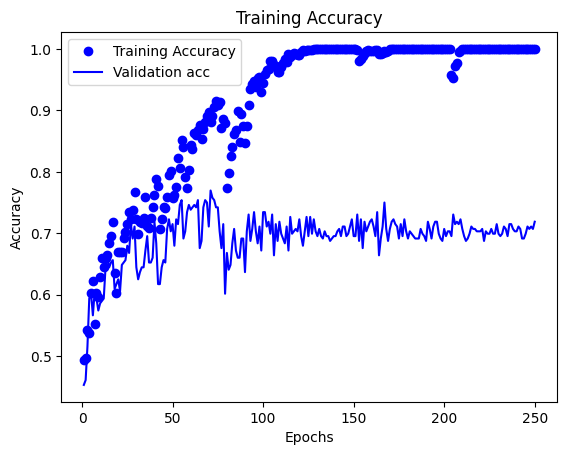

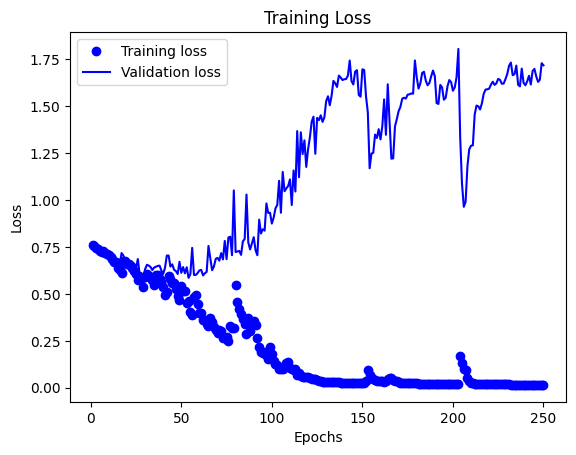

127


In [7]:
history_dict = history.history #Get the data stored from training

#Define plot of the accuracy
def plot_acc():
    plt.clf()
    acc = history_dict['accuracy']
    val_acc = history_dict['val_accuracy']
    epochs = range(1, len(acc) + 1)
    solid_blue_line = 'b'
    blue_dots = 'bo'

    plt.plot(epochs, acc, blue_dots, label = 'Training Accuracy')
    plt.plot(epochs, val_acc, solid_blue_line, label = 'Validation acc')
    plt.title('Training Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

#Define plot of the loss
def plot_loss():
    loss = history_dict['loss']
    val_loss = history_dict['val_loss']
    epochs = range(1, len(loss) + 1)
    solid_blue_line = 'b'
    blue_dots = 'bo'

    plt.plot(epochs, loss, blue_dots, label = 'Training loss')
    plt.plot(epochs, val_loss, solid_blue_line, label = 'Validation loss')
    plt.title('Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

plot_acc()
plot_loss()
early_stopping_epoch = np.argmax(history.history["accuracy"])
print(early_stopping_epoch)

In [8]:
tf.keras.backend.clear_session()
'''
new_model = tf.keras.models.load_model('saved_model/my_model')
new_model.summary()
'''

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128)               322048    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 32)                4128      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 16)                528       
                                                                 
 dense_2 (Dense)             (None, 2)                 34        
                                                                 
Total params: 326,738
Trainable params: 326,738
Non-trai

In [8]:
history = model4.fit(
    train_data,                     
    train_label,
    epochs=early_stopping_epoch, #Stop where overfitting start
    batch_size = 150, 
    validation_split=0.2,
)

Epoch 1/127
7/7 [==============================] - 2s 224ms/step - loss: 0.0151 - accuracy: 1.0000 - val_loss: 1.6540 - val_accuracy: 0.7109
Epoch 2/127
7/7 [==============================] - 1s 157ms/step - loss: 0.0152 - accuracy: 1.0000 - val_loss: 1.6269 - val_accuracy: 0.6992
Epoch 3/127
7/7 [==============================] - 1s 160ms/step - loss: 0.0149 - accuracy: 1.0000 - val_loss: 1.7138 - val_accuracy: 0.7031
Epoch 4/127
7/7 [==============================] - 1s 155ms/step - loss: 0.0145 - accuracy: 1.0000 - val_loss: 1.7598 - val_accuracy: 0.7109
Epoch 5/127
7/7 [==============================] - 1s 155ms/step - loss: 0.0143 - accuracy: 1.0000 - val_loss: 1.7710 - val_accuracy: 0.7070
Epoch 6/127
7/7 [==============================] - 1s 150ms/step - loss: 0.0144 - accuracy: 1.0000 - val_loss: 1.6793 - val_accuracy: 0.6914
Epoch 7/127
7/7 [==============================] - 1s 155ms/step - loss: 0.0144 - accuracy: 1.0000 - val_loss: 1.7083 - val_accuracy: 0.6992
Epoch 8/127
7

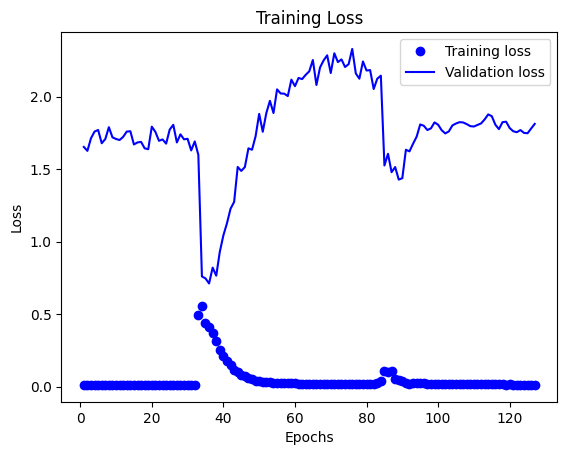

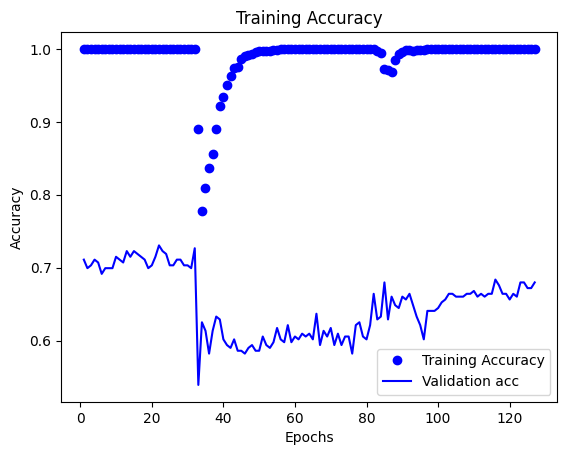

In [9]:
history_dict = history.history #Get the data stored from training
plot_loss()
plot_acc()

In [10]:
score, acc = model4.evaluate(test_data, test_label, verbose=2)
print('Test score:', score)
print('Test accuracy:', acc)
model4.save('saved_model/my_model')

10/10 - 0s - loss: 1.7139 - accuracy: 0.6812 - 309ms/epoch - 31ms/step
Test score: 1.7139488458633423
Test accuracy: 0.6812499761581421


INFO:tensorflow:Assets written to: saved_model/my_model\assets


INFO:tensorflow:Assets written to: saved_model/my_model\assets
